In [1]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device(device)

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

/home/jovyan/dldiy/lib/python3.8/site-packages/torchvision/transforms/functional.py:404: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


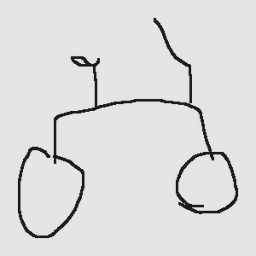

In [4]:
x = preprocess(PIL.Image.open('data/domain_net/quickdraw/bicycle/4546760737292288.png'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

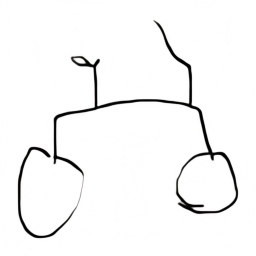

In [5]:
import torch.nn.functional as F

z_logits = enc(x.to(device))
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

In [11]:
import torch.nn as nn

from encoder import Encoder
from decoder import Decoder

class VAE(nn.Module):
    def __init__(self, image_size=256, z_dim=500, input_channels=3, output_channels=3):
        super(VAE, self).__init__()
        self.encoder1 = Encoder(n_hid=image_size, vocab_size=z_dim, input_channels=input_channels,
                               device=torch.device(device), requires_grad=True)
        self.encoder2 = Encoder(n_hid=image_size, vocab_size=z_dim, input_channels=input_channels,
                               device=torch.device(device), requires_grad=True)
        self.decoder = Decoder(n_hid=image_size, vocab_size=z_dim, output_channels=output_channels,
                               device=torch.device(device), requires_grad=True)
        
    def encode(self, x):
        return self.encoder1.forward(x), self.encoder2.forward(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder.forward(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x.float())
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z.float())
        return x_reconst, mu, log_var

In [12]:
# Hyper-parameters
num_epochs = 15
input_channels = output_channels = 3
image_size = 256
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets

data = datasets.ImageFolder('data/domain_net/quickdraw', preprocess)
data_loader = DataLoader(data, batch_size=16, shuffle=True, num_workers=6)

In [14]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, input_channels, image_size, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 31.75 GiB total capacity; 27.51 GiB already allocated; 70.50 MiB free; 28.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF